In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [55]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data

,nace,lpk,hourly_rate,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,lpk1,lpk2,lpk1_nc,outlier_iqr_lpk1_nc,nace_nc
0,C,722,8.13,0,0,1,0,1,7,72,478,False,0
1,C,721,8.20,0,0,1,1,1,7,72,478,False,0
2,C,722,8.20,0,0,1,0,1,7,72,478,False,0
3,C,334,2.51,0,1,0,1,1,3,33,300,False,0
4,M,522,2.19,1,1,0,1,1,5,52,500,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36508,N,711,2.84,0,0,1,0,1,7,71,478,False,0
36509,N,711,2.84,0,0,1,0,1,7,71,478,False,0
36510,N,711,2.84,0,0,1,2,1,7,71,478,False,0
36511,N,711,2.84,0,0,1,0,1,7,71,478,False,0


# Data selection and filtering

Select lpk level

In [56]:
lpk_level = 'lpk1_nc'
#From 'lpk', 'lpk1', 'lpk2', 'lpk1_nc'

Include outliers?

In [57]:
remove_outliers = True
if remove_outliers == True:
    data=data.query('outlier_iqr_lpk1_nc==False')
    print('Outliers removed')
else:
    print('Outliers retained')

data.shape

Outliers removed


(35019, 13)

In [58]:
remove_col = ['nace', 'lpk', 'lpk1', 'lpk2', 'lpk1_nc', 'outlier_iqr_lpk1_nc']
remove_col.remove(lpk_level)

In [59]:
data_sf = pd.get_dummies(data, prefix=lpk_level ,columns=[lpk_level])
data_sf.drop(columns=remove_col, inplace=True )
data_sf

,hourly_rate,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,nace_nc,lpk1_nc_100,lpk1_nc_200,lpk1_nc_300,lpk1_nc_478,lpk1_nc_500,lpk1_nc_900
0,8.13,0,0,1,0,1,0,0,0,0,1,0,0
1,8.20,0,0,1,1,1,0,0,0,0,1,0,0
2,8.20,0,0,1,0,1,0,0,0,0,1,0,0
3,2.51,0,1,0,1,1,0,0,0,1,0,0,0
4,2.19,1,1,0,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36508,2.84,0,0,1,0,1,0,0,0,0,1,0,0
36509,2.84,0,0,1,0,1,0,0,0,0,1,0,0
36510,2.84,0,0,1,2,1,0,0,0,0,1,0,0
36511,2.84,0,0,1,0,1,0,0,0,0,1,0,0


In [60]:
y = data_sf['hourly_rate']
X = data_sf.drop(columns='hourly_rate')
y.shape , X.shape

((35019,), (35019, 12))

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=1)

## Some models (first tests)

### Simple Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression(fit_intercept=True)
model_LR.fit(X=X_train,y=y_train)
y_pred = model_LR.predict(X_test)

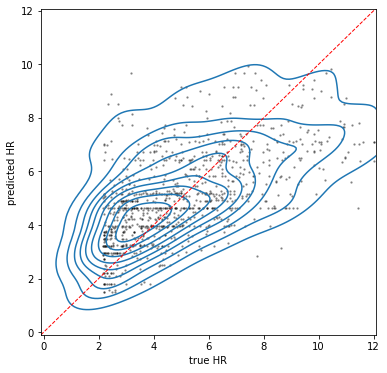

In [63]:
r = range(500,1500)
prediction = y_pred[r]
true_labels = y_test.iloc[r]
plt.figure(figsize = (6,6))
sns.scatterplot(x=true_labels, y=prediction,  s=5, color='black', alpha=0.5)
sns.kdeplot(x=true_labels, y=prediction)
plt.xlim(plt.ylim())
plt.xlabel('true HR')
plt.ylabel('predicted HR')
plt.plot(plt.ylim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False);

In [64]:
np.sqrt(mean_squared_error(y_test, y_pred))

2.0122950803702055

### Decision Tree Regressor

In [65]:
from sklearn.tree import DecisionTreeRegressor
model_DTR = DecisionTreeRegressor()
model_DTR.fit(X=X_train,y=y_train)
y_pred = model_DTR.predict(X_test)

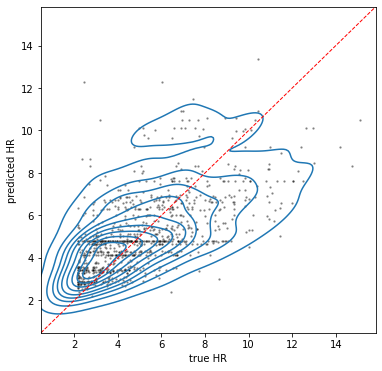

In [66]:
r = range(500,1500)
prediction = y_pred[r]
true_labels = y_test.iloc[r]
plt.figure(figsize = (6,6))
sns.scatterplot(x=true_labels, y=prediction,  s=5, color='black', alpha=0.5)
sns.kdeplot(x=true_labels, y=prediction)
plt.xlim(plt.ylim())
plt.xlabel('true HR')
plt.ylabel('predicted HR')
plt.plot(plt.ylim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False);

In [67]:
np.sqrt(mean_squared_error(y_test, y_pred))

1.9537264158096252

### RandomForestRegressor

In [68]:
from sklearn.ensemble import RandomForestRegressor
model_RFR = RandomForestRegressor(random_state=0)
model_RFR.fit(X=X_train,y=y_train)
y_pred = model_RFR.predict(X_test)

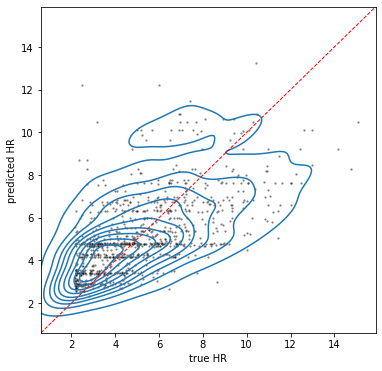

In [69]:
r = range(500,1500)
prediction = y_pred[r]
true_labels = y_test.iloc[r]
plt.figure(figsize = (6,6))
sns.scatterplot(x=true_labels, y=prediction,  s=5, color='black', alpha=0.5)
sns.kdeplot(x=true_labels, y=prediction)
plt.xlim(plt.ylim())
plt.xlabel('true HR')
plt.ylabel('predicted HR')
plt.plot(plt.ylim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False);

In [70]:
np.sqrt(mean_squared_error(y_test, y_pred))

1.9545320531054422